# Heston Model Simulation

**Mekrami Redwan**

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize_scalar
from scipy.stats import norm
import scipy.stats as ss
import scipy.integrate
import math
import cmath


sns.set_theme()

The basic Heston model assumes that $S_{t}$, the price of the asset, is determined by a stochastic process, ${ }^{[2]}$
$$
d S_{t}=\mu S_{t} d t+\sqrt{\nu_{t}} S_{t} d W_{t}^{S},
$$
where $\nu_{t}$, the instantaneous variance, is given by a Feller square-root or $\mathrm{CIR}$ process,
$$
d \nu_{t}=\kappa\left(\theta-\nu_{t}\right) d t+\xi \sqrt{\nu_{t}} d W_{t}^{\nu}
$$

# 1) Discretization Schemes

In [21]:
Npaths = 10**5

T = 1
steps = 80
dt = T/steps

rho = -0.9


W = np.random.randn(Npaths,steps)
Z_X = np.random.randn(Npaths,steps)  
Z_V = rho * Z_X + np.sqrt(1-rho**2)*W

## Euler Scheme

Euler-Maruyama scheme: 
$$
S_{t+d t}=S_{t}( 1 + r dt+\sqrt{v_{t} d t}Z_{s})
$$
and
$$
v_{t+d t}=v_{t}+\kappa\left(\theta-v_{t}^{+}\right) d t+\sigma \sqrt{v_{t}^{+} d t} Z_{v}
$$
where $x^{+}=\max (0, x)$ and where $Z_{s}$ and $Z_{v}$ are standardized Gaussian random variables such that $corr(Z_{s}, Z_{v}) = ρ$.


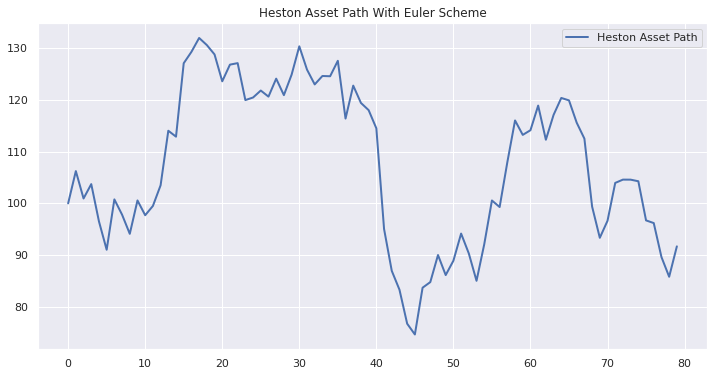

In [22]:
def generate_heston_euler(S_0 = 100, r = 0.02, kappa = 4, theta = 0.3, v_0 = 0.3, xi = 0.9, T=1):
    '''
      Generate Heston Volatility and Asset Paths With Euler Scheme
      Args:
          S_0:
            Spot Price of the Underlying
          r:
            Risk Free Rate
          T:
            Maturity
          kappa :
            Volatility rate
          theta:
            Long run mean
          v_0 :
            Spot Volatility
          xi : 
            Volatility of volatility 
      Returns:
          X:
            Asset Path
          V :
            Volatility Path
          X_bs :
            Asset Path under Black Scholes
    '''
    dt = T/steps
    size = (Npaths, steps)
    W = np.random.randn(Npaths, steps)
    Z_X = np.random.randn(Npaths, steps)  
    Z_V = rho * Z_X + np.sqrt(1-rho**2)*W
    X = np.zeros(size)
    V = np.zeros(size)
    X[:,0] = S_0
    V[:,0] = v_0
    for t in range(steps-1): 
        X[:,t+1] = X[:,t] * (1 + r*dt+ np.sqrt(np.maximum(V[:,t], 0) *dt) * Z_X[:,t])
        V[:,t+1] = V[:,t] + kappa * (theta - np.maximum(V[:,t], 0))*dt + ( xi * np.sqrt(np.maximum(V[:,t], 0) * dt) * Z_V[:,t])

    return X, V 

X, V = generate_heston_euler(S_0 = 100, r = 0.02, kappa = 4, theta = 0.3, v_0 = 0.3, xi = 0.9, T=1)
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(X[0], linewidth=2, label = 'Heston Asset Path')
plt.title('Heston Asset Path With Euler Scheme')
plt.legend()
plt.show()

## Milstein Scheme

$$
S_{t+d t}=S_{t}+r S_{t} dt+\sqrt{v_{t}^{+} d t} S_{t} Z_{s}+\frac{1}{2} v_{t}^{+} S_{t} d t\left(Z_{s}^{2}-1\right)
$$

$$
v_{t+d t}=v_{t}+\kappa\left(\theta-v_{t}^{+}\right) d t+\sigma \sqrt{v_{t}^{+} d t} Z_{v}+\frac{1}{4} \sigma^{2} d t\left(Z_{v}^{2}-1\right)
$$

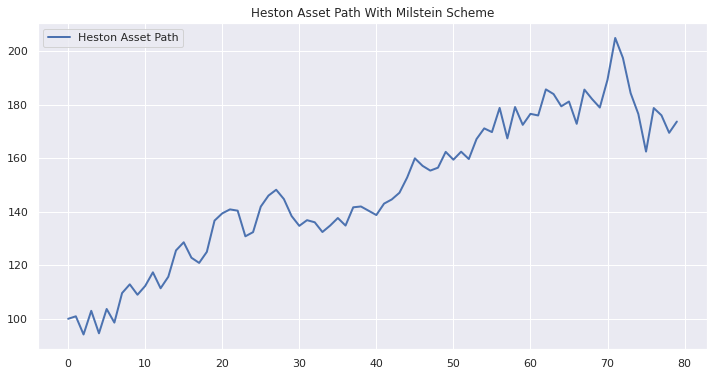

In [23]:
def generate_heston_milstein(S_0 = 100, r = 0.02, kappa = 4, theta = 0.3, v_0 = 0.3, xi = 0.9, T=1):
    '''
      Generate Heston Volatility and Asset Paths with Milstein Scheme
      Args:
          S_0:
            Spot Price of the Underlying
          r:
            Risk Free Rate
          T:
            Maturity
          kappa :
            Volatility rate
          theta:
            Long run mean
          v_0 :
            Spot Volatility
          xi : 
            Volatility of volatility 
      Returns:
          X:
            Asset Path
          V :
            Volatility Path
          X_bs :
            Asset Path under Black Scholes
    '''
    dt = T/steps
    size = (Npaths, steps)
    W = np.random.randn(Npaths,steps)
    Z_X = np.random.randn(Npaths,steps)  
    Z_V = rho * Z_X + np.sqrt(1-rho**2)*W
    X = np.zeros(size)
    V = np.zeros(size)
    X[:,0] = S_0
    V[:,0] = v_0
    for t in range(steps-1): 
        X[:,t+1] = X[:,t] * ( 1 + r*dt+ (np.sqrt(np.maximum(V[:,t] , 0) *dt) * Z_X[:,t]) + (0.5 * np.maximum(V[:,t] , 0)* dt * ((Z_X[:,t]**2) - 1)) )
        V[:,t+1] = V[:,t] + (kappa * dt * (theta - np.maximum(V[:,t] , 0))) + (xi * np.sqrt(np.maximum(V[:,t] , 0) * dt) * Z_V[:,t]) + (0.25 * (xi**2) * dt * ((Z_V[:,t]**2) - 1))
    return X, V

X, V = generate_heston_milstein(S_0 = 100, r = 0.02, kappa = 4, theta = 0.3, v_0 = 0.3, xi = 0.9, T=1)
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(X[0], linewidth=2, label = 'Heston Asset Path')
plt.title('Heston Asset Path With Milstein Scheme')
plt.legend()
plt.show()

## Andersen Scheme : Quadratic Exponential

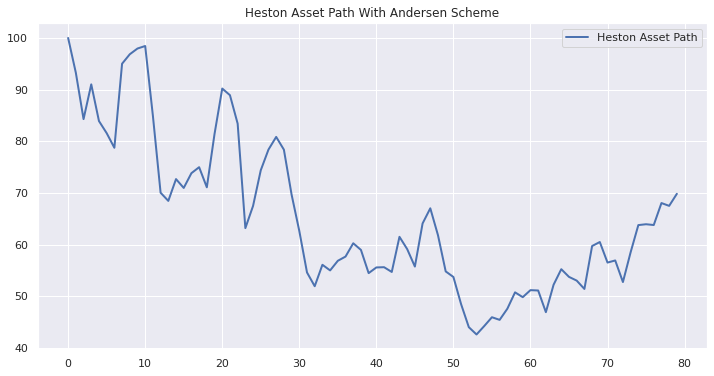

In [24]:
def generate_heston_andersen(S_0 = 100, r = 0.02, kappa = 4, theta = 0.3, v_0 = 0.3, xi = 0.9, T=1, nu_c = 1.5):
    '''
      Generate Heston Volatility and Asset Paths With Andersen Scheme
      Args:
          S_0:
            Spot Price of the Underlying
          r:
            Risk Free Rate
          T:
            Maturity
          kappa :
            Volatility rate
          theta:
            Long run mean
          v_0 :
            Spot Volatility
          xi : 
            Volatility of volatility 
          nu_c :
            Andersen Constant
      Returns:
          X:
            Asset Path
          V :
            Volatility Path
    '''
    dt = T/steps
    size = (Npaths,steps)
    X = np.zeros(size)
    V = np.zeros(size)
    X[:,0] = S_0
    V[:,0] = v_0

    gamma_1 = 0.5 
    gamma_2 = 0.5

    c_bar = (0.25/kappa) * (xi**2) * (1 - np.exp(-kappa*dt))
    delta = 4 * kappa * theta/(xi**2)

    for t in range(steps - 1):
      kappa_bar = (4 * kappa * V[:,t] * np.exp(-kappa*dt)) / ( (xi**2) * (1 - np.exp(-kappa*dt)) )

      m = theta + (V[:,t] - theta) * np.exp(-kappa*dt)
      s = np.sqrt( (V[:,t] * (xi**2) * np.exp(-kappa*dt)/kappa) * (1-np.exp(-kappa*dt)) + (theta * (xi**2)/ (2*kappa)) * (1 - np.exp(-kappa*dt))**2)
      nu = (s**2)/(m**2)

      U = np.random.uniform(size = Npaths) 

      b =( (2/nu)-1 + np.sqrt(2/nu)*np.sqrt((2/nu) -1) )**0.5
      a = m/(1+b**2)

      Z = norm.ppf(U)
      
      p = (nu - 1) /(nu + 1) 
      beta = (1-p)/m

      K_0 = -dt*(kappa*rho*theta)/xi  
      K_1 = gamma_1*dt*(kappa*rho/xi - 0.5) - rho/xi
      K_2 = gamma_2*dt*(kappa*rho/xi - 0.5) + rho/xi
      K_3 = gamma_1*dt*(1 - rho**2)
      K_4 = gamma_2*dt*(1 - rho**2)
      
      V[:,t+1] = (nu <= nu_c) * a*(b + Z)**2 + (nu > nu_c) *  (U>p) * (1/beta) * np.log((1-p)/(1-U))
      X[:,t+1] =  X[:,t] * np.exp(r*dt + K_0 + K_1 * V[:,t] + K_2 * V[:,t + 1] + np.sqrt(K_3* V[:,t] +  K_4*V[:,t+1]) * np.random.randn(Npaths))
      
     
    return X, V

X, V = generate_heston_andersen(S_0 = 100)
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(X[0], linewidth=2, label = 'Heston Asset Path')
plt.title('Heston Asset Path With Andersen Scheme')
plt.legend()
plt.show()

## Almost Exact Approximation

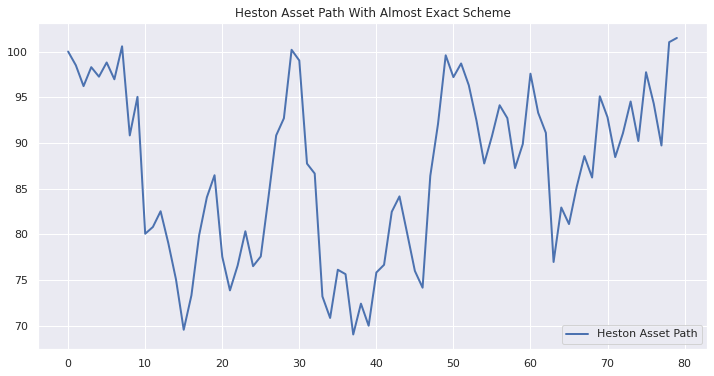

In [25]:
from scipy.stats import norm

def generate_heston_almost_exact(S_0 = 100, r = 0.02, kappa = 4, theta = 0.3, v_0 = 0.3, xi = 0.9, T=1):
    '''
      Generate Heston Volatility and Asset Paths With Almost Exact Scheme
      Args:
          S_0:
            Spot Price of the Underlying
          r:
            Risk Free Rate
          T:
            Maturity
          kappa :
            Volatility rate
          theta:
            Long run mean
          v_0 :
            Spot Volatility
          xi : 
            Volatility of volatility 
      Returns:
          X:
            Asset Path
          V :
            Volatility Path
    '''
    dt = T/steps
    size = (Npaths,steps)
    X = np.zeros(size)
    V = np.zeros(size)
    X[:,0] = np.log(S_0)
    V[:,0] = v_0

    c_bar = ((xi**2)/(4*kappa)) * (1- np.exp(-kappa*dt))
    delta = (4*kappa*theta)/(xi**2)
    for t in range(steps-1):
      
      k_bar = V[:,t] *(4*kappa*np.exp(-kappa*dt))/((xi**2)*(1-np.exp(-kappa*dt)))
      Z = np.random.randn(Npaths)
      Y = np.random.noncentral_chisquare(df= delta, nonc = k_bar, size = Npaths)
      
      K_0 = dt*(r - kappa*rho*theta/xi)
      K_1 = dt*(kappa*rho/xi - 0.5) - rho/xi
      K_2 = rho/xi
      K_3 = dt*(1- rho**2)

      V[:,t+1]  = c_bar * Y
      X[:,t+1]  = X[:,t]  + K_0 + (K_1 * V[:,t] )  + (K_2 * V[:,t+1]) + (np.sqrt(K_3 *V[:,t]) * Z)
    return np.exp(X), V

X, V = generate_heston_almost_exact(S_0 = 100, r = 0.02, kappa = 4, theta = 0.3, v_0 = 0.3, xi = 0.9, T = 1)
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(X[0], linewidth=2, label = 'Heston Asset Path')
plt.title('Heston Asset Path With Almost Exact Scheme')
plt.legend()
plt.show()

# 2) Pricing


## Closed-Form Solution




In [26]:
def call_price(path, K = 100, r = 0.02, T = 1):
    '''
      Compute the price of Call
      Args:
          path : 
            path of the underlying
          r:
            Risk-free interest rate
          T:
            Maturity
      Returns:
          The price of a Call with Monte carlo
      '''
    S_T = np.array(path[:,-1])
    Z = np.maximum(S_T-K, 0)
    return(np.exp(-r*T) * Z)

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import enum 


def HestonCallClosedForm(cf, S_0 = 100, r=0.02, tau = 1, K = [120], N=5000, L=10):
  if(type(K) == int):
    K = [K]
  if K is not np.array:
    K = np.array(K).reshape([len(K),1])

  if K is not np.array:
    K = np.array(K).reshape([len(K),1])

    # Assigning i=sqrt(-1)
    i = np.complex(0.0,1.0)
    x0 = np.log(S_0 / K)

    # Truncation domain
    a = 0.0 - L * np.sqrt(tau)
    b = 0.0 + L * np.sqrt(tau)

    # Summation from k = 0 to k=N-1
    k = np.linspace(0,N-1,N).reshape([N,1])
    u = k * np.pi / (b - a);

    # Determine coefficients for put prices
    H_k = CallPutCoefficients(a,b,k)
    mat = np.exp(i * np.outer((x0 - a) , u))
    temp = cf(u) * H_k
    temp[0] = 0.5 * temp[0]
    value = np.exp(-r * tau) * K * np.real(mat.dot(temp))
    return value[0][0]

def Chi_Psi(a,b,c,d,k):
    psi = np.sin(k * np.pi * (d - a) / (b - a)) - np.sin(k * np.pi * (c - a) / (b - a))
    psi[1:] = psi[1:] * (b - a) / (k[1:] * np.pi)
    psi[0] = d - c

    chi = 1.0 / (1.0 + np.power((k * np.pi / (b - a)) , 2.0))
    expr1 = np.cos(k * np.pi * (d - a)/(b - a)) * np.exp(d) - np.cos(k *np.pi* (c - a) / (b - a)) * np.exp(c)
    expr2 = k * np.pi / (b - a) * np.sin(k * np.pi * (d - a) / (b - a)) - k * np.pi / (b - a) * np.sin(k* np.pi * (c - a) / (b - a)) * np.exp(c)
    chi = chi * (expr1 + expr2)

    value = {"chi":chi,"psi":psi }
    return value


def CallPutCoefficients(a,b,k):
    c = 0.0
    d = b
    coef = Chi_Psi(a,b,c,d,k)
    Chi_k = coef["chi"]
    Psi_k = coef["psi"]
    if a < b and b < 0.0:
      H_k = np.zeros([len(k),1])
    else:
      H_k = 2.0 / (b - a) * (Chi_k - Psi_k)
    return H_k


def ChFHestonModel(r,tau,kappa,gamma,vbar,v0,rho):
  i = np.complex(0.0,1.0)
  D1 = lambda u: np.sqrt(np.power(kappa-gamma*rho*i*u,2)+(u*u+i*u)*gamma*gamma)
  g = lambda u: (kappa-gamma*rho*i*u-D1(u))/(kappa-gamma*rho*i*u+D1(u))
  C = lambda u: (1.0-np.exp(-D1(u)*tau))/(gamma*gamma*(1.0-g(u)*np.exp(-D1(u)*tau)))*(kappa-gamma*rho*i*u-D1(u))
  # Note that we exclude the term -r*tau, as the discounting is performed in the COS method
  A = lambda u: r * i*u *tau + kappa*vbar*tau/gamma/gamma *(kappa - gamma*rho*i*u-D1(u))- 2*kappa*vbar/gamma/gamma*np.log((1.0-g(u)*np.exp(-D1(u)*tau))/(1.0-g(u)))
  # Characteristic function for the Heston's model
  cf = lambda u: np.exp(A(u) + C(u)*v0)
  return cf

def EUOptionPriceFromMCPathsGeneralized(S,K,T,r):
 # S is a vector of Monte Carlo samples at T
 result = np.zeros([len(K),1])
 for (idx,k) in enumerate(K):
    result[idx] = np.exp(-r*T)*np.mean(np.maximum(S-k,0.0))
 return result

cf = ChFHestonModel(r = 0.02, tau = 1, kappa = 4, gamma = 0.9 ,vbar = 0.3, v0 = 0.04, rho = - 0.9)

HestonCallClosedForm(cf = cf)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


11.226094737164445

## Euler Discretization

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


K =  70
error 1.300059653168205
ic lenght 0.5312314183607185 

K =  100
error 2.0498450804579633
ic lenght 0.41824497808561034 

K =  130
error 2.069302675013736
ic lenght 0.29775640826823846 



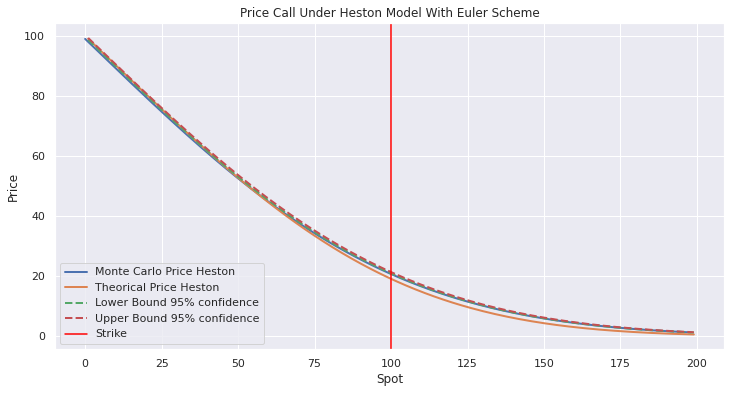

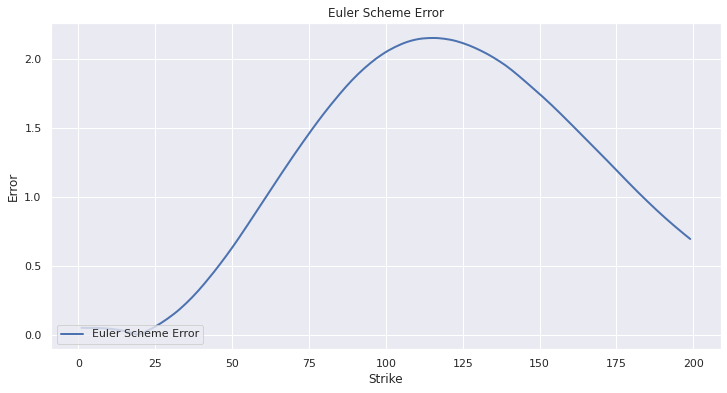

In [28]:
def call_strike_payoff_heston_euler():
    '''
      Compute Heston Call Price Function of Strikes With Euler Scheme
      Args:
         NA
      Returns:
         Call_prices_heston:
            List Of Calls Prices Function of Strikes
          Up_boud:
            List Of Upper Bounds of The Monte Carlo Estimator Function of Strikes
          Down_bound:
            List Of Lower Bounds of The Monte Carlo Estimator Function of Strikes
          Theorical_call_prices_heston:
            List Of Theorical Heston Prices Function of Strikes
          Error:
            List Of Absolute Error Between Monte Carlo Estimator and Theorical Heston Prices Function of Strikes
          ic_length:
            List Of The Confidence Intervals Lengths Function Of Strikes
    '''
    call_prices_heston = []
    theorical_call_prices_heston = []
    up_boud = []
    down_bound = []
    error = []
    ic_length = []
    path_heston = generate_heston_euler(S_0 = 100)[0]

    for k in range(1,200):
        prices = call_price(path_heston,k)
        p = np.mean(prices)
        s = np.std(prices)
      
        down = p-1.96*s/np.sqrt(Npaths)
        up = p+1.96*s/np.sqrt(Npaths)
        th_price = HestonCallClosedForm(cf = cf, S_0=100, K = k)

        call_prices_heston.append(p)
        up_boud.append(up)
        down_bound.append(down)
        theorical_call_prices_heston.append(th_price)
        error.append(np.abs(th_price-p))
        ic_length.append(up - down)
        if(k==70 or k == 100 or k == 130):
          print('K = ', k)
          print('error', np.abs(th_price-p))
          print('ic lenght',up - down, '\n' )



    return(call_prices_heston, up_boud, down_bound, theorical_call_prices_heston,error,ic_length )

call_prices_heston, up_boud, down_bound, theorical_call_prices_heston, error_euler, ic_length_euler = call_strike_payoff_heston_euler()

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(call_prices_heston, linewidth=2, label = 'Monte Carlo Price Heston')
plt.plot(range(1,200), theorical_call_prices_heston, linewidth=2, label = 'Theorical Price Heston')
plt.plot(range(1,200), down_bound, linewidth=2, label = 'Lower Bound 95% confidence', ls = '--')
plt.plot(range(1,200), up_boud, linewidth=2, label = 'Upper Bound 95% confidence', ls = '--')
plt.axvline(x = 100, color= "red", label = "Strike")
plt.title('Price Call Under Heston Model With Euler Scheme')
plt.xlabel('Spot')
plt.ylabel('Price')
plt.legend(loc = 'lower left')
plt.show()


fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(1,200), error_euler, linewidth=2, label = 'Euler Scheme Error')
plt.title('Euler Scheme Error')
plt.xlabel('Strike')
plt.ylabel('Error')
plt.legend(loc = 'lower left')
plt.show()

## Millstein

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


K =  70
error 1.1650554305825196
ic lenght 0.5335999359546548 

K =  100
error 1.9854786063323182
ic lenght 0.42094020003222 

K =  130
error 2.0816544917893527
ic lenght 0.3011205271358577 



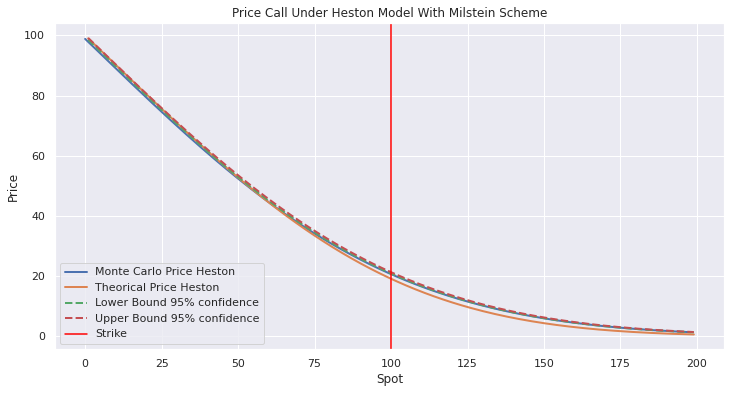

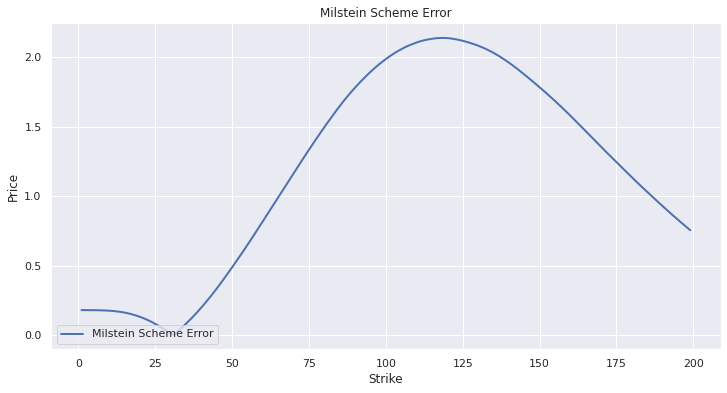

In [29]:
def call_strike_payoff_heston_milstein():
    '''
      Compute Heston Call Price Function of Strikes With Milstein Scheme
      Args:
         NA
      Returns:
         Call_prices_heston:
            List Of Calls Prices Function of Strikes
          Up_boud:
            List Of Upper Bounds of The Monte Carlo Estimator Function of Strikes
          Down_bound:
            List Of Lower Bounds of The Monte Carlo Estimator Function of Strikes
          Theorical_call_prices_heston:
            List Of Theorical Heston Prices Function of Strikes
          Error:
            List Of Absolute Error Between Monte Carlo Estimator and Theorical Heston Prices Function of Strikes
          ic_length:
            List Of The Confidence Intervals Lengths Function Of Strikes
    '''
    call_prices_heston = []
    theorical_call_prices_heston = []
    up_boud = []
    down_bound = []
    error = []
    ic_length = []
    path_heston = generate_heston_milstein(S_0 = 100)[0]

    for k in range(1,200):
        prices = call_price(path_heston,k)
        p = np.mean(prices)
        s = np.std(prices)
      
        down = p-1.96*s/np.sqrt(Npaths)
        up = p+1.96*s/np.sqrt(Npaths)
        th_price = HestonCallClosedForm(cf = cf, S_0=100, K = k)

        call_prices_heston.append(p)
        up_boud.append(up)
        down_bound.append(down)
        theorical_call_prices_heston.append(th_price)
        error.append(np.abs(th_price-p))
        ic_length.append(up - down)
        if(k==70 or k == 100 or k == 130):
          print('K = ', k)
          print('error', np.abs(th_price-p))
          print('ic lenght',up - down, '\n' )

    return(call_prices_heston, up_boud, down_bound, theorical_call_prices_heston,error,ic_length )

call_prices_heston, up_boud, down_bound, theorical_call_prices_heston, error_milstein, ic_length_milstein = call_strike_payoff_heston_milstein()

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(call_prices_heston, linewidth=2, label = 'Monte Carlo Price Heston')
plt.plot(range(1,200), theorical_call_prices_heston, linewidth=2, label = 'Theorical Price Heston')
plt.plot(range(1,200), down_bound, linewidth=2, label = 'Lower Bound 95% confidence', ls = '--')
plt.plot(range(1,200), up_boud, linewidth=2, label = 'Upper Bound 95% confidence', ls = '--')
plt.axvline(x = 100, color= "red", label = "Strike")
plt.title('Price Call Under Heston Model With Milstein Scheme')
plt.xlabel('Spot')
plt.ylabel('Price')
plt.legend(loc = 'lower left')
plt.show()


fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(1,200), error_milstein, linewidth=2, label = 'Milstein Scheme Error')
plt.title('Milstein Scheme Error')
plt.xlabel('Strike')
plt.ylabel('Price')
plt.legend(loc = 'lower left')
plt.show()

## Andersen : Quadratic Explonential

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


K =  70
error 1.4207568275041353
ic lenght 0.5344987550101621 

K =  100
error 2.1641400352258557
ic lenght 0.4219375486543768 

K =  130
error 2.1743992128564873
ic lenght 0.3019209258722775 



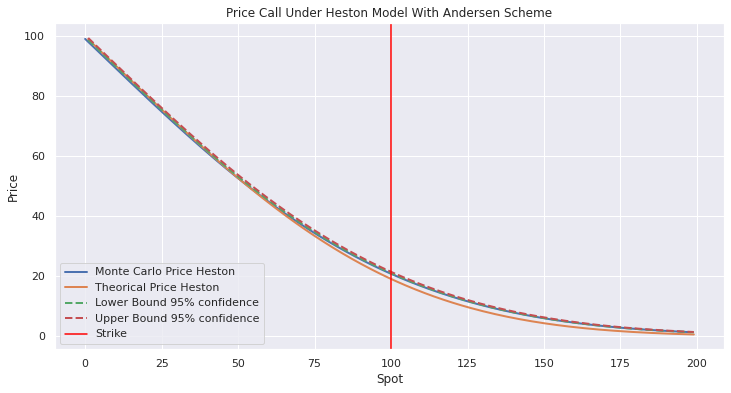

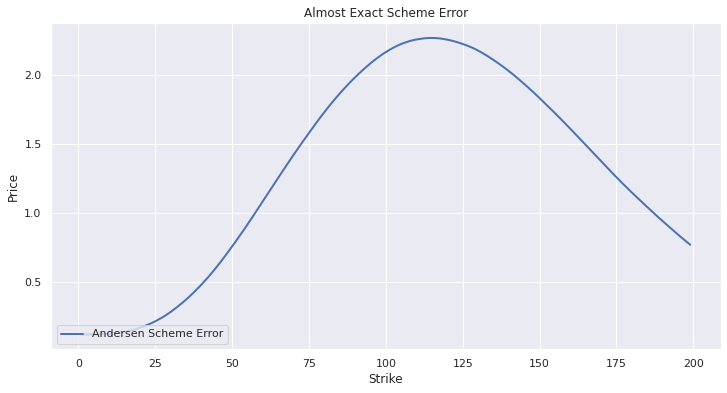

In [30]:
def call_strike_payoff_heston_andersen():
    '''
      Compute Heston Call Price Function of Strikes With Andersen Scheme
      Args:
         NA
      Returns:
         Call_prices_heston:
            List Of Calls Prices Function of Strikes
          Up_bound:
            List Of Upper Bounds of The Monte Carlo Estimator Function of Strikes
          Down_bound:
            List Of Lower Bounds of The Monte Carlo Estimator Function of Strikes
          Theorical_call_prices_heston:
            List Of Theorical Heston Prices Function of Strikes
          Error:
            List Of Absolute Error Between Monte Carlo Estimator and Theorical Heston Prices Function of Strikes
          ic_length:
            List Of The Confidence Intervals Lengths Function Of Strikes
    '''  
    call_prices_heston = []
    theorical_call_prices_heston = []
    up_boud = []
    down_bound = []
    error = []
    ic_length = []
    path_heston = generate_heston_andersen(S_0 = 100)[0]

    for k in range(1,200):
        prices = call_price(path_heston,k)
        p = np.mean(prices)
        s = np.std(prices)
      
        down = p-1.96*s/np.sqrt(Npaths)
        up = p+1.96*s/np.sqrt(Npaths)
        th_price = HestonCallClosedForm(cf = cf, S_0=100, K = k)
        
        call_prices_heston.append(p)
        up_boud.append(up)
        down_bound.append(down)
        theorical_call_prices_heston.append(th_price)
        error.append(np.abs(th_price-p))
        ic_length.append(up - down)
        if(k==70 or k == 100 or k == 130):
          print('K = ', k)
          print('error', np.abs(th_price-p))
          print('ic lenght',up - down, '\n' )


    return(call_prices_heston, up_boud, down_bound, theorical_call_prices_heston,error,ic_length )

call_prices_heston, up_boud, down_bound, theorical_call_prices_heston, error_andersen, ic_length_andersen = call_strike_payoff_heston_andersen()

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(call_prices_heston, linewidth=2, label = 'Monte Carlo Price Heston')
plt.plot(range(1,200), theorical_call_prices_heston, linewidth=2, label = 'Theorical Price Heston')
plt.plot(range(1,200), down_bound, linewidth=2, label = 'Lower Bound 95% confidence', ls = '--')
plt.plot(range(1,200), up_boud, linewidth=2, label = 'Upper Bound 95% confidence', ls = '--')
plt.axvline(x = 100, color= "red", label = "Strike")
plt.title('Price Call Under Heston Model With Andersen Scheme')
plt.xlabel('Spot')
plt.ylabel('Price')
plt.legend(loc = 'lower left')
plt.show()


fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(1,200), error_andersen, linewidth=2, label = 'Andersen Scheme Error')
plt.title('Almost Exact Scheme Error')
plt.xlabel('Strike')
plt.ylabel('Price')
plt.legend(loc = 'lower left')
plt.show()

## Almost Exact Scheme

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


K =  130
error 1.9730876872250267
ic lenght 0.296653018334851 



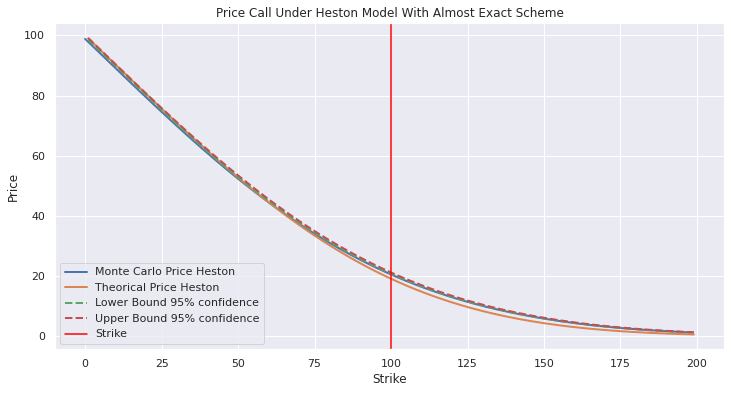

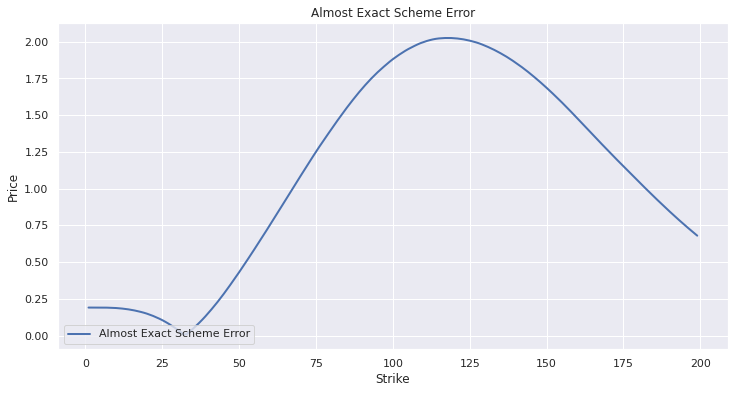

In [31]:
def call_strike_payoff_heston_almost_exact():
    '''
      Compute Heston Call Price Function of Strikes With Almost Exact Scheme
      Args:
         NA
      Returns:
         Call_prices_heston:
            List Of Calls Prices Function of Strikes
          Up_boud:
            List Of Upper Bounds of The Monte Carlo Estimator Function of Strikes
          Down_bound:
            List Of Lower Bounds of The Monte Carlo Estimator Function of Strikes
          Theorical_call_prices_heston:
            List Of Theorical Heston Prices Function of Strikes
          Error:
            List Of Absolute Error Between Monte Carlo Estimator and Theorical Heston Prices Function of Strikes
          ic_length:
            List Of The Confidence Intervals Lengths Function Of Strikes
    '''
    call_prices_heston = []
    theorical_call_prices_heston = []
    up_boud = []
    down_bound = []
    error = []
    ic_length = []
    path_heston = generate_heston_almost_exact(S_0 = 100)[0]

    for k in range(1,200):
        prices = call_price(path_heston,k)
        p = np.mean(prices)
        s = np.std(prices)
      
        down = p-1.96*s/np.sqrt(Npaths)
        up = p+1.96*s/np.sqrt(Npaths)
        th_price = HestonCallClosedForm(cf = cf, S_0=100, K = k)

        call_prices_heston.append(p)
        up_boud.append(up)
        down_bound.append(down)
        theorical_call_prices_heston.append(th_price)
        error.append(np.abs(th_price-p))
        ic_length.append(up - down)
        if(k==70 or k == 100 or k == 130):
          print('K = ', k)
          print('error', np.abs(th_price-p))
          print('ic lenght',up - down, '\n' )

    return(call_prices_heston, up_boud, down_bound, theorical_call_prices_heston,error,ic_length )

call_prices_heston, up_boud, down_bound, theorical_call_prices_heston, error_almost, ic_length_almost = call_strike_payoff_heston_almost_exact()

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(call_prices_heston, linewidth=2, label = 'Monte Carlo Price Heston')
plt.plot(range(1,200), theorical_call_prices_heston, linewidth=2, label = 'Theorical Price Heston')
plt.plot(range(1,200), down_bound, linewidth=2, label = 'Lower Bound 95% confidence', ls = '--')
plt.plot(range(1,200), up_boud, linewidth=2, label = 'Upper Bound 95% confidence', ls = '--')
plt.axvline(x = 100, color= "red", label = "Strike")
plt.title('Price Call Under Heston Model With Almost Exact Scheme')
plt.xlabel('Strike')
plt.ylabel('Price')
plt.legend(loc = 'lower left')
plt.show()


fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(1,200), error_almost, linewidth=2, label = 'Almost Exact Scheme Error')
plt.title('Almost Exact Scheme Error')
plt.xlabel('Strike')
plt.ylabel('Price')
plt.legend(loc = 'lower left')
plt.show()



# 3) Errors Comparaison

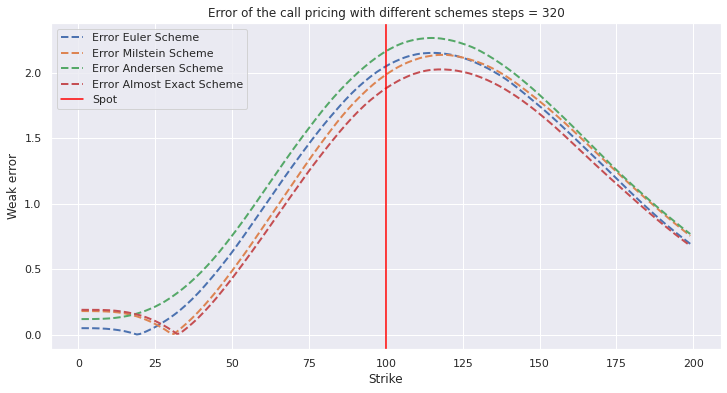

In [32]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(1,200), error_euler, linewidth=2, label = 'Error Euler Scheme', ls = '--')
plt.plot(range(1,200), error_milstein, linewidth=2, label = 'Error Milstein Scheme', ls = '--')
plt.plot(range(1,200), error_andersen, linewidth=2, label = 'Error Andersen Scheme', ls = '--')
plt.plot(range(1,200), error_almost, linewidth=2, label = 'Error Almost Exact Scheme', ls = '--')
plt.axvline(x = 100, color= "red", label = "Spot")
plt.title('Error of the call pricing with different schemes steps = 320')
plt.xlabel('Strike')
plt.ylabel('Weak error')
plt.legend()
plt.show()

# Greeks

In [33]:
K = 100
Npaths = 2000

def Delta(x):
    '''
      Compute the Delta of Call for the 4 schemes
      Args:
          x:
            Spot Price of the Underlying
      Returns:
          Deltas of the Call of spot x for the 4 schemes
    '''
    step = 0.9
    step_2 = 0.9

    path_plus_euler = generate_heston_euler(S_0 = x * (1 + step))[0]
    path_sub_euler =  generate_heston_euler(S_0 = x * (1 - step))[0]

    path_plus_milstein = generate_heston_milstein(S_0 = x * (1 + step))[0]
    path_sub_milstein =  generate_heston_milstein(S_0 = x * (1 - step))[0]

    path_plus_andersen = generate_heston_andersen(S_0 = x * (1 + step_2))[0]
    path_sub_andersen =  generate_heston_andersen(S_0 = x * (1 - step_2))[0]

    path_plus_almost_exact = generate_heston_almost_exact(S_0 = x * (1 + step_2))[0]
    path_sub_almost_exact =  generate_heston_almost_exact(S_0 = x * (1 - step_2))[0]

    delta_euler = np.mean(call_price(path_plus_euler, K) - call_price(path_sub_euler, K)) / (2*step*x)
    delta_milstein = np.mean(call_price(path_plus_milstein, K) - call_price(path_sub_milstein, K)) / (2*step*x) 
    delta_andersen = np.mean(call_price(path_plus_andersen, K) - call_price(path_sub_andersen, K)) / (2*step_2*x)
    delta_almost_exact = np.mean(call_price(path_plus_almost_exact, K) - call_price(path_sub_almost_exact,K)) / (2*step_2*x)
 

    return(delta_euler, delta_milstein, delta_andersen, delta_almost_exact)


def Gamma(x):
    '''
      Compute the Gamma of Call for the 4 schemes
      Args:
          x:
            Spot Price of the Underlying
      Returns:
          The Gamma of the Call of spot x for the 4 schemes
      '''
    step = 0.99
    step_2 = 0.99

    path_euler = generate_heston_euler(S_0 = x)[0]
    path_plus_euler = generate_heston_euler(S_0 = x * (1 + step))[0]
    path_sub_euler =  generate_heston_euler(S_0 = x * (1 - step))[0]

    path_milstein = generate_heston_milstein(S_0 = x)[0]
    path_plus_milstein = generate_heston_milstein(S_0 = x * (1 + step))[0]
    path_sub_milstein =  generate_heston_milstein(S_0 = x * (1 - step))[0]

    path_andersen = generate_heston_andersen(S_0 = x)[0]
    path_plus_andersen = generate_heston_andersen(S_0 = x * (1 + step_2))[0]
    path_sub_andersen =  generate_heston_andersen(S_0 = x * (1 - step_2))[0]

    path_almost_exact = generate_heston_almost_exact(S_0 = x)[0]
    path_plus_almost_exact = generate_heston_almost_exact(S_0 = x * (1 + step_2))[0]
    path_sub_almost_exact =  generate_heston_almost_exact(S_0 = x * (1 - step_2))[0]

    gamma_euler = np.mean(call_price(path_plus_euler,K) - 2*call_price(path_euler,K) + call_price(path_sub_euler, K)) / ((step*x)**2)
    gamma_milstein = np.mean(call_price(path_plus_milstein,K) - 2*call_price(path_milstein,K) + call_price(path_sub_milstein, K)) / ((step*x)**2)
    gamma_andersen = np.mean(call_price(path_plus_almost_exact,K) - 2*call_price(path_andersen,K) + call_price(path_sub_andersen, K)) / ((step_2*x)**2)
    gamma_almost_exact = np.mean(call_price(path_plus_almost_exact,K) - 2*call_price(path_almost_exact,K) + call_price(path_sub_almost_exact, K)) / ((step_2*x)**2)

    return(gamma_euler, gamma_milstein, gamma_andersen, gamma_almost_exact )

-------------please wait for 2 min----------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: Unrecognized location 'Lower left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: MatplotlibDeprecationWarning: Unrecognized location 'Lower left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


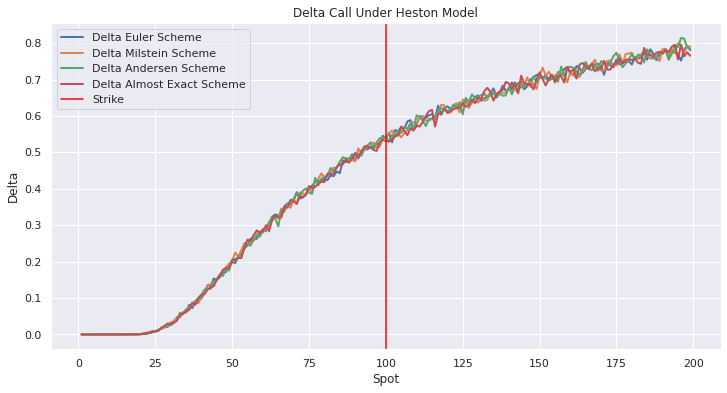

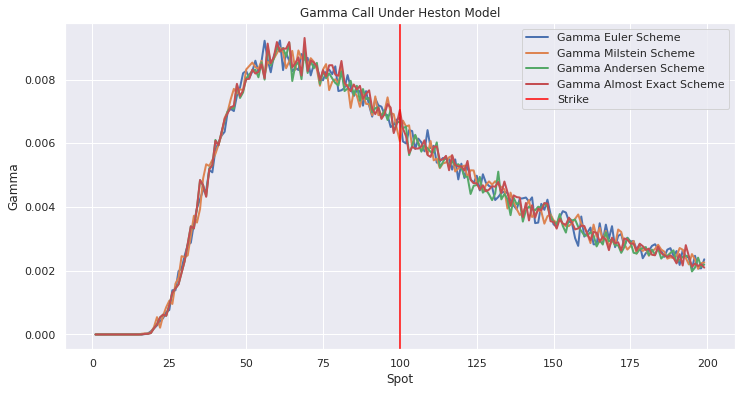

In [34]:
def compute_greeks():
    '''
      Plot the greeks 
      Args:
          NA: Plot the greeks for a range of spot
      return:
        Lists of Deltas for the four schemes of spot x

    '''
    delta_euler = []
    delta_milstein = []
    delta_andersen = []
    delta_almost_exact = []

    gamma_euler = []
    gamma_milstein =[] 
    gamma_andersen = []
    gamma_almost_exact = []

    for x in range(1,200):
        d = Delta(x)
        g = Gamma(x)
        delta_euler.append(d[0])
        delta_milstein.append(d[1])
        delta_andersen.append(d[2])
        delta_almost_exact.append(d[3])

        gamma_euler.append(g[0])
        gamma_milstein.append(g[1])
        gamma_andersen.append(g[2])
        gamma_almost_exact.append(g[3])

    return(delta_euler, delta_milstein, delta_andersen, delta_almost_exact, gamma_euler, gamma_milstein, gamma_andersen, gamma_almost_exact)


print('-------------please wait for 2 min----------------------------')
delta_euler, delta_milstein, delta_andersen, delta_almost_exact, gamma_euler, gamma_milstein, gamma_andersen, gamma_almost_exact = compute_greeks()

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(1,200), delta_euler, linewidth=2, label = "Delta Euler Scheme")
plt.plot(range(1,200), delta_milstein, linewidth=2, label = "Delta Milstein Scheme")
plt.plot(range(1,200), delta_andersen, linewidth=2, label = "Delta Andersen Scheme")
plt.plot(range(1,200), delta_almost_exact, linewidth=2, label = "Delta Almost Exact Scheme")
plt.axvline(x = 100, color= "red", label = "Strike")
plt.title('Delta Call Under Heston Model')
plt.xlabel('Spot')
plt.ylabel('Delta')
plt.legend(loc = 'Lower left')

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(1,200), gamma_euler, linewidth=2, label = "Gamma Euler Scheme")
plt.plot(range(1,200), gamma_milstein, linewidth=2, label = "Gamma Milstein Scheme")
plt.plot(range(1,200), gamma_andersen, linewidth=2, label = "Gamma Andersen Scheme")
plt.plot(range(1,200), gamma_almost_exact, linewidth=2, label = "Gamma Almost Exact Scheme")
plt.axvline(x = 100, color= "red", label = "Strike")
plt.title('Gamma Call Under Heston Model')
plt.xlabel('Spot')
plt.ylabel('Gamma')
plt.legend(loc = 'Lower left')
plt.show()